In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

#### Loading the retweet networks

In [2]:
# Reading data
basepath = '../../../data/03_backbone_nets'

before_data = pd.read_csv(os.path.join(basepath, 'before_campaign_backbone.csv'))
during_data = pd.read_csv(os.path.join(basepath, 'electoral_campaign_backbone.csv'))
after_data = pd.read_csv(os.path.join(basepath, 'after_elections_backbone.csv'))

# Forcing the conversion to string
before_data['source'] = before_data['source'].astype(str)
before_data['target'] = before_data['target'].astype(str)
during_data['source'] = during_data['source'].astype(str)
during_data['target'] = during_data['target'].astype(str)
after_data['source'] = after_data['source'].astype(str)
after_data['target'] = after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", before_data.shape)
print("During data has shape: ", during_data.shape)
print("After data has shape: ", after_data.shape)

Before data has shape:  (38209, 4)
During data has shape:  (56953, 4)
After data has shape:  (42864, 4)


In [3]:
# Creating graphs
# use nx.DIGraph() for directed graph
before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

# Some basic stats
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")

Before graph has:  12008  nodes and  38209  edges
During graph has:  18150  nodes and  56953  edges
After graph has:  15943  nodes and  42864  edges


In [4]:
# from int to floating point weight columns
before_data['weight'] = before_data['weight'].astype(float)
during_data['weight'] = during_data['weight'].astype(float)
after_data['weight'] = after_data['weight'].astype(float)

In [5]:
# Creating graphs
# use nx.DiGraph() for directed graph
d_before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
d_during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
d_after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("Before graph has: ", d_before_graph.number_of_nodes(), " nodes and ", d_before_graph.number_of_edges(), " edges")
print("During graph has: ", d_during_graph.number_of_nodes(), " nodes and ", d_during_graph.number_of_edges(), " edges")
print("After graph has: ", d_after_graph.number_of_nodes(), " nodes and ", d_after_graph.number_of_edges(), " edges")

Before graph has:  12008  nodes and  38209  edges
During graph has:  18150  nodes and  56953  edges
After graph has:  15943  nodes and  42864  edges


#### Community detection via the Louvain algorithm

In [6]:
print("Running community detection algorithms on the 'Before graph'")
before_comms = nx.community.louvain_communities(before_graph, weight='weight', seed=123)

print("Running community detection algorithms on the 'During graph'")
during_comms = nx.community.louvain_communities(during_graph, weight='weight', seed=123)

print("Running community detection algorithms on the 'After graph'")
after_comms = nx.community.louvain_communities(after_graph, weight='weight', seed=123)

Running community detection algorithms on the 'Before graph'
Running community detection algorithms on the 'During graph'
Running community detection algorithms on the 'After graph'


In [7]:
print("Before graph has: ", len(before_comms), " communities")
print("During graph has: ", len(during_comms), " communities")
print("After graph has: ", len(after_comms), " communities")

Before graph has:  57  communities
During graph has:  438  communities
After graph has:  428  communities


In [8]:
print(nx.community.modularity(before_graph, before_comms))
print(nx.community.modularity(during_graph, during_comms))
print(nx.community.modularity(after_graph, after_comms))

0.6716162864964508
0.7076918151489552
0.6964413568661887


In [30]:
output_path = "../../../data/04_communities"

#store the comms
pickle.dump(before_comms, open(os.path.join(output_path, 'before_comms.pickle'), 'wb'))
pickle.dump(during_comms, open(os.path.join(output_path, 'during_comms.pickle'), 'wb'))
pickle.dump(after_comms, open(os.path.join(output_path, 'after_comms.pickle'), 'wb'))

#### Community detection via the Leiden algorithm

In [10]:
import igraph as ig
import leidenalg as la

In [11]:
# let's first try with undirected graphs
before_igraph = ig.Graph.from_networkx(before_graph)
during_igraph = ig.Graph.from_networkx(during_graph)
after_igraph = ig.Graph.from_networkx(after_graph)

In [12]:
print("Running the Leiden community detection algorithm on the weighted 'Before graph'")
la_before_comms = la.find_partition(before_igraph, la.ModularityVertexPartition, weights='weight', seed=123)#, resolution_parameter = 0.05)

print("Running the Leiden community detection algorithm on the weighted 'During graph'")
la_during_comms = la.find_partition(during_igraph, la.ModularityVertexPartition, weights='weight', seed=123)
                                    
print("Running the Leiden community detection algorithm on the weighted 'After graph'")
la_after_comms = la.find_partition(after_igraph, la.ModularityVertexPartition, weights='weight', seed=123)

Running the Leiden community detection algorithm on the weighted 'Before graph'
Running the Leiden community detection algorithm on the weighted 'During graph'
Running the Leiden community detection algorithm on the weighted 'After graph'


In [18]:
print("Weighted before graph has: ", len(la_before_comms), " communities")
print("Weighted during graph has: ", len(la_during_comms), " communities")
print("Weighted after graph has: ", len(la_after_comms), " communities")

Weighted before graph has:  63  communities
Weighted during graph has:  445  communities
Weighted after graph has:  445  communities


In [15]:
_la_before_comms = []

for comm in la_before_comms:
    nx_comm = set()

    for n in comm:
        nx_comm.add(before_igraph.vs[n]['_nx_name'])
    
    _la_before_comms.append(nx_comm)

#
_la_during_comms = []

for comm in la_during_comms:
    nx_comm = set()

    for n in comm:
        nx_comm.add(during_igraph.vs[n]['_nx_name'])
    
    _la_during_comms.append(nx_comm)

#
_la_after_comms = []

for comm in la_after_comms:
    nx_comm = set()

    for n in comm:
        nx_comm.add(after_igraph.vs[n]['_nx_name'])
    
    _la_after_comms.append(nx_comm)


In [ ]:
###########################################
###########################################
###########################################

In [16]:
d_before_igraph = ig.Graph.from_networkx(d_before_graph)
d_during_igraph = ig.Graph.from_networkx(d_during_graph)
d_after_igraph = ig.Graph.from_networkx(d_after_graph)

In [17]:
# then let's try for directed weighted graphs
print("Running the Leiden community detection algorithm on the weighted directed 'Before graph'")
d_la_before_comms = la.find_partition(d_before_igraph, la.ModularityVertexPartition, weights='weight', seed=123)#, resolution_parameter = 0.05)

print("Running the Leiden community detection algorithm on the weighted directed 'During graph'")
d_la_during_comms = la.find_partition(d_during_igraph, la.ModularityVertexPartition, weights='weight', seed=123) #, resolution_parameter = 0.05)

print("Running the Leiden community detection algorithm on the weighted directed 'After graph'")
d_la_after_comms = la.find_partition(d_after_igraph, la.ModularityVertexPartition, weights='weight', seed=123)#, resolution_parameter = 0.05)

Running the Leiden community detection algorithm on the weighted directed 'Before graph'
Running the Leiden community detection algorithm on the weighted directed 'During graph'
Running the Leiden community detection algorithm on the weighted directed 'After graph'


In [19]:
print("Weighted-Directed Before graph has: ", len(d_la_before_comms), " communities")
print("Weighted-Directed During graph has: ", len(d_la_during_comms), " communities")
print("Weighted-Directed After graph has: ", len(d_la_after_comms), " communities")

Weighted-Directed Before graph has:  65  communities
Weighted-Directed During graph has:  445  communities
Weighted-Directed After graph has:  442  communities


In [20]:
_d_la_before_comms = []

for comm in d_la_before_comms:
    nx_comm = set()

    for n in comm:
        nx_comm.add(d_before_igraph.vs[n]['_nx_name'])
    
    _d_la_before_comms.append(nx_comm)

#
_d_la_during_comms = []

for comm in d_la_during_comms:
    nx_comm = set()

    for n in comm:
        nx_comm.add(d_during_igraph.vs[n]['_nx_name'])
    
    _d_la_during_comms.append(nx_comm)

#
_d_la_after_comms = []

for comm in d_la_after_comms:
    nx_comm = set()

    for n in comm:
        nx_comm.add(d_after_igraph.vs[n]['_nx_name'])
    
    _d_la_after_comms.append(nx_comm)

#### Community analysis

##### Size

In [21]:
before_comm_sizes = [len(comm) for comm in before_comms]
during_comm_sizes = [len(comm) for comm in during_comms]
after_comm_sizes = [len(comm) for comm in after_comms]

la_before_comm_sizes = [len(comm) for comm in la_before_comms]
la_during_comm_sizes = [len(comm) for comm in la_during_comms]
la_after_comm_sizes = [len(comm) for comm in la_after_comms]

d_la_before_comm_sizes = [len(comm) for comm in d_la_before_comms]
d_la_during_comm_sizes = [len(comm) for comm in d_la_during_comms]
d_la_after_comm_sizes = [len(comm) for comm in d_la_after_comms]

In [22]:
print(np.quantile(before_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))
print(np.quantile(during_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))
print(np.quantile(after_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))

print()

print(np.quantile(la_before_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))
print(np.quantile(la_during_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))
print(np.quantile(la_after_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))

print()

print(np.quantile(d_la_before_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))
print(np.quantile(d_la_during_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))
print(np.quantile(d_la_after_comm_sizes, [0.25, 0.5, 0.75, .8, .9, .95, .99]))

[2.00000e+00 3.00000e+00 9.00000e+00 1.56000e+01 2.17600e+02 1.88740e+03
 2.67132e+03]
[   2.      2.      3.      3.      5.     10.   1797.66]
[   2.      2.      3.      3.      5.     10.   1799.06]

[2.00000e+00 3.00000e+00 8.00000e+00 1.58000e+01 3.33600e+02 1.81980e+03
 2.40124e+03]
[   2.     2.     3.     3.     5.     9.  1573.2]
[   2.     2.     3.     3.     5.    10.  1751.2]

[2.0000e+00 3.0000e+00 7.0000e+00 1.4600e+01 1.5000e+02 1.7754e+03
 2.8456e+03]
[   2.      2.      3.      3.      6.     10.   1560.36]
[   2.      2.      3.      3.      5.     10.   1570.57]


Text(0, 0.5, 'Frequency')

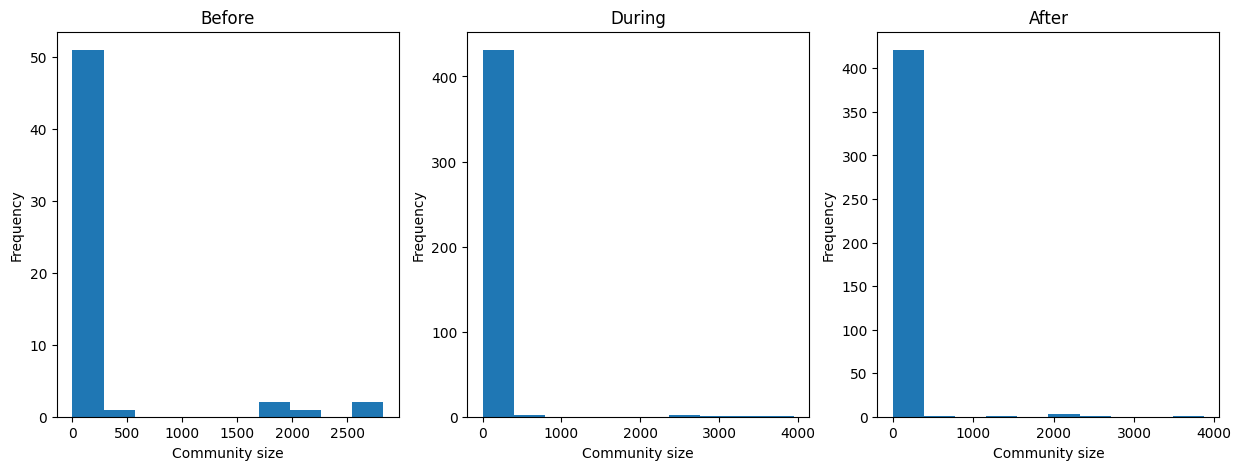

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(before_comm_sizes) #, bins=100
ax[0].set_title("Before")
ax[0].set_xlabel("Community size")
ax[0].set_ylabel("Frequency")

ax[1].hist(during_comm_sizes) #, bins=100
ax[1].set_title("During")
ax[1].set_xlabel("Community size")
ax[1].set_ylabel("Frequency")

ax[2].hist(after_comm_sizes) #, bins=100
ax[2].set_title("After")
ax[2].set_xlabel("Community size")
ax[2].set_ylabel("Frequency")

##### Quality: Modularity | Coverage | Conductance

In [24]:
print('Louvain')
print(nx.community.modularity(before_graph, before_comms))
print(nx.community.modularity(during_graph, during_comms))
print(nx.community.modularity(after_graph, after_comms))

print()

print('Leiden - und')
print(nx.community.modularity(before_graph, _la_before_comms))
print(nx.community.modularity(during_graph, _la_during_comms))
print(nx.community.modularity(after_graph, _la_after_comms))

print()

print('Leiden - dir')
print(nx.community.modularity(d_before_graph, _d_la_before_comms))
print(nx.community.modularity(d_during_graph, _d_la_during_comms))
print(nx.community.modularity(d_after_graph, _d_la_after_comms))

Louvain
0.6716162864964508
0.7076918151489552
0.6964413568661887

Leiden - und
0.6816530980854407
0.7122938468435009
0.7016635973223897

Leiden - dir
0.6813961873966092
0.7106680552928235
0.7016507924729827


In [25]:
# coverage, performance

# coverage is the ratio of the number of intra-community edges by the total number of edges.
# by definition, an ideal cluster structure, where the clusters are disconnected 
# from each other, yields a coverage of 1, as all edges of the graph fall within clusters.

# performance counts the number of correctly “interpreted” pairs of vertices,
# i.e. two vertices belonging to the same community and connected by an edge, 
# or two vertices belonging to different communities and not connected by an edge.
print('Louvain')
print(nx.community.partition_quality(before_graph, before_comms))
print(nx.community.partition_quality(during_graph, during_comms))
print(nx.community.partition_quality(after_graph, after_comms))

print()

print('Leiden - und')

print(nx.community.partition_quality(before_graph, _la_before_comms))
print(nx.community.partition_quality(during_graph, _la_during_comms))
print(nx.community.partition_quality(after_graph, _la_after_comms))

print()

print('Leiden - dir')
print(nx.community.partition_quality(d_before_graph, _d_la_before_comms))
print(nx.community.partition_quality(d_during_graph, _d_la_during_comms))
print(nx.community.partition_quality(d_after_graph, _d_la_after_comms))

Louvain
(0.8563950901620038, 0.8224044801314268)
(0.886766280968518, 0.8529191372245084)
(0.8673012318029115, 0.8579145803210476)

Leiden - und
(0.8582794629537543, 0.8387284715716853)
(0.8890313065158991, 0.8569075423563774)
(0.8748366927958193, 0.859609600765895)

Leiden - dir
(0.8739302258630166, 0.8188545369964345)
(0.8958790581707724, 0.8482070713395254)
(0.8674178798058977, 0.8647488870797109)


In [26]:
def eval_conductance(graph, communities):
    conductance = np.zeros([len(communities), len(communities)])
    for i, comm_i in enumerate(communities):
        for j, comm_j in enumerate(communities):
            conductance[i, j] = nx.algorithms.cuts.conductance(graph, comm_i, comm_j, weight='weight')
    return conductance

In [27]:
# conductance
before_conductance = eval_conductance(before_graph, before_comms)
during_conductance = eval_conductance(during_graph, during_comms)
after_conductance = eval_conductance(after_graph, after_comms)

la_before_conductance = eval_conductance(before_graph, _la_before_comms)
la_during_conductance = eval_conductance(during_graph, _la_during_comms)
la_after_conductance = eval_conductance(after_graph, _la_after_comms)

d_la_before_conductance = eval_conductance(d_before_graph, _d_la_before_comms)
d_la_during_conductance = eval_conductance(d_during_graph, _d_la_during_comms)
d_la_after_conductance = eval_conductance(d_after_graph, _d_la_after_comms)

In [28]:
# average conductance
print('Louvain')
print(np.mean(before_conductance))
print(np.mean(during_conductance))
print(np.mean(after_conductance))

print()

print('Leiden - und')
print(np.mean(la_before_conductance))
print(np.mean(la_during_conductance))
print(np.mean(la_after_conductance))

print()

print('Leiden - dir')
print(np.mean(d_la_before_conductance))
print(np.mean(d_la_during_conductance))
print(np.mean(d_la_after_conductance))

Louvain
0.00997345068642207
0.0012051331218415821
0.001216929018812646

Leiden - und
0.009279021075986308
0.0011930339209752987
0.0011916132440472416

Leiden - dir
0.03333889649670617
0.004642519269733513
0.004646408380561376


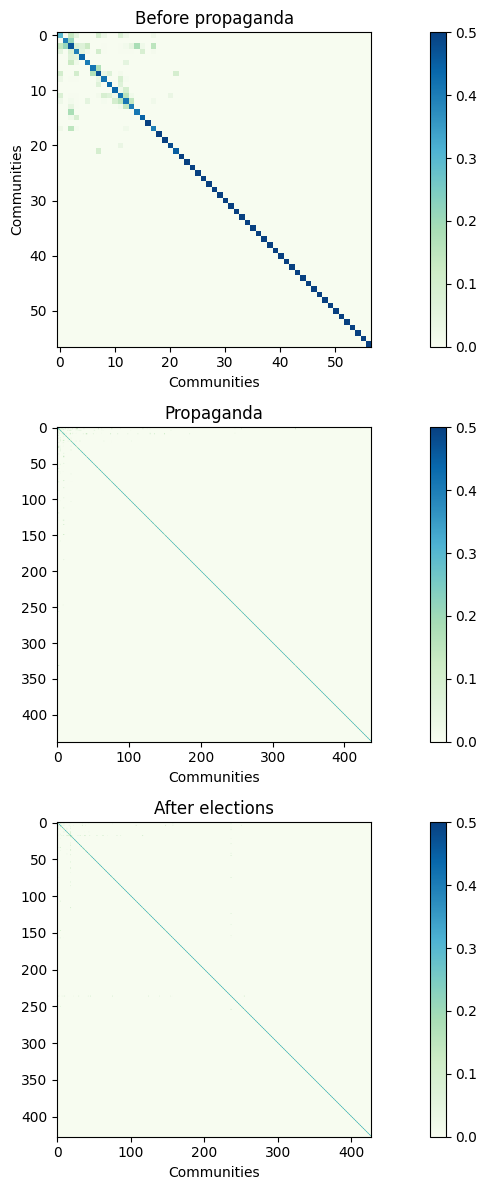

In [29]:
# plot the conductance matrix with a heatmap
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

im_b = ax[0].imshow(before_conductance, cmap='GnBu')
cbar_b = ax[0].figure.colorbar(im_b)

im_d = ax[1].imshow(during_conductance, cmap='GnBu')
cbar_d = ax[1].figure.colorbar(im_d)

im_a = ax[2].imshow(after_conductance, cmap='GnBu')
cbar_a = ax[2].figure.colorbar(im_a)

ax[0].set_title("Before propaganda")
ax[1].set_title("Propaganda")
ax[2].set_title("After elections")

ax[0].set_xlabel("Communities")
ax[0].set_ylabel("Communities")

ax[1].set_xlabel("Communities")
ax[2].set_xlabel("Communities")

fig.tight_layout()